## BTC Forecasting in PyTorch using LSTM

In [186]:
import yfinance as yf 

symbol = 'BTC-USD'

btc_data = yf.download(symbol)
btc_data.to_csv('BTC-USD.csv')

[*********************100%%**********************]  1 of 1 completed


In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
 
import torch
import torch.nn as nn

#Obtener el dataset
data = pd.read_csv('BTC-USD.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
data.drop(['Adj Close', 'Open', 'High', 'Low'], axis=1, inplace=True)
data

,Close,Volume
Date,,
2014-09-17,457.334015,21056800
2014-09-18,424.440002,34483200
2014-09-19,394.795990,37919700
2014-09-20,408.903992,36863600
2014-09-21,398.821014,26580100
...,...,...
2024-11-20,94339.492188,71730956426
2024-11-21,98504.726562,106024505582
2024-11-22,98997.664062,78473580551


In [188]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

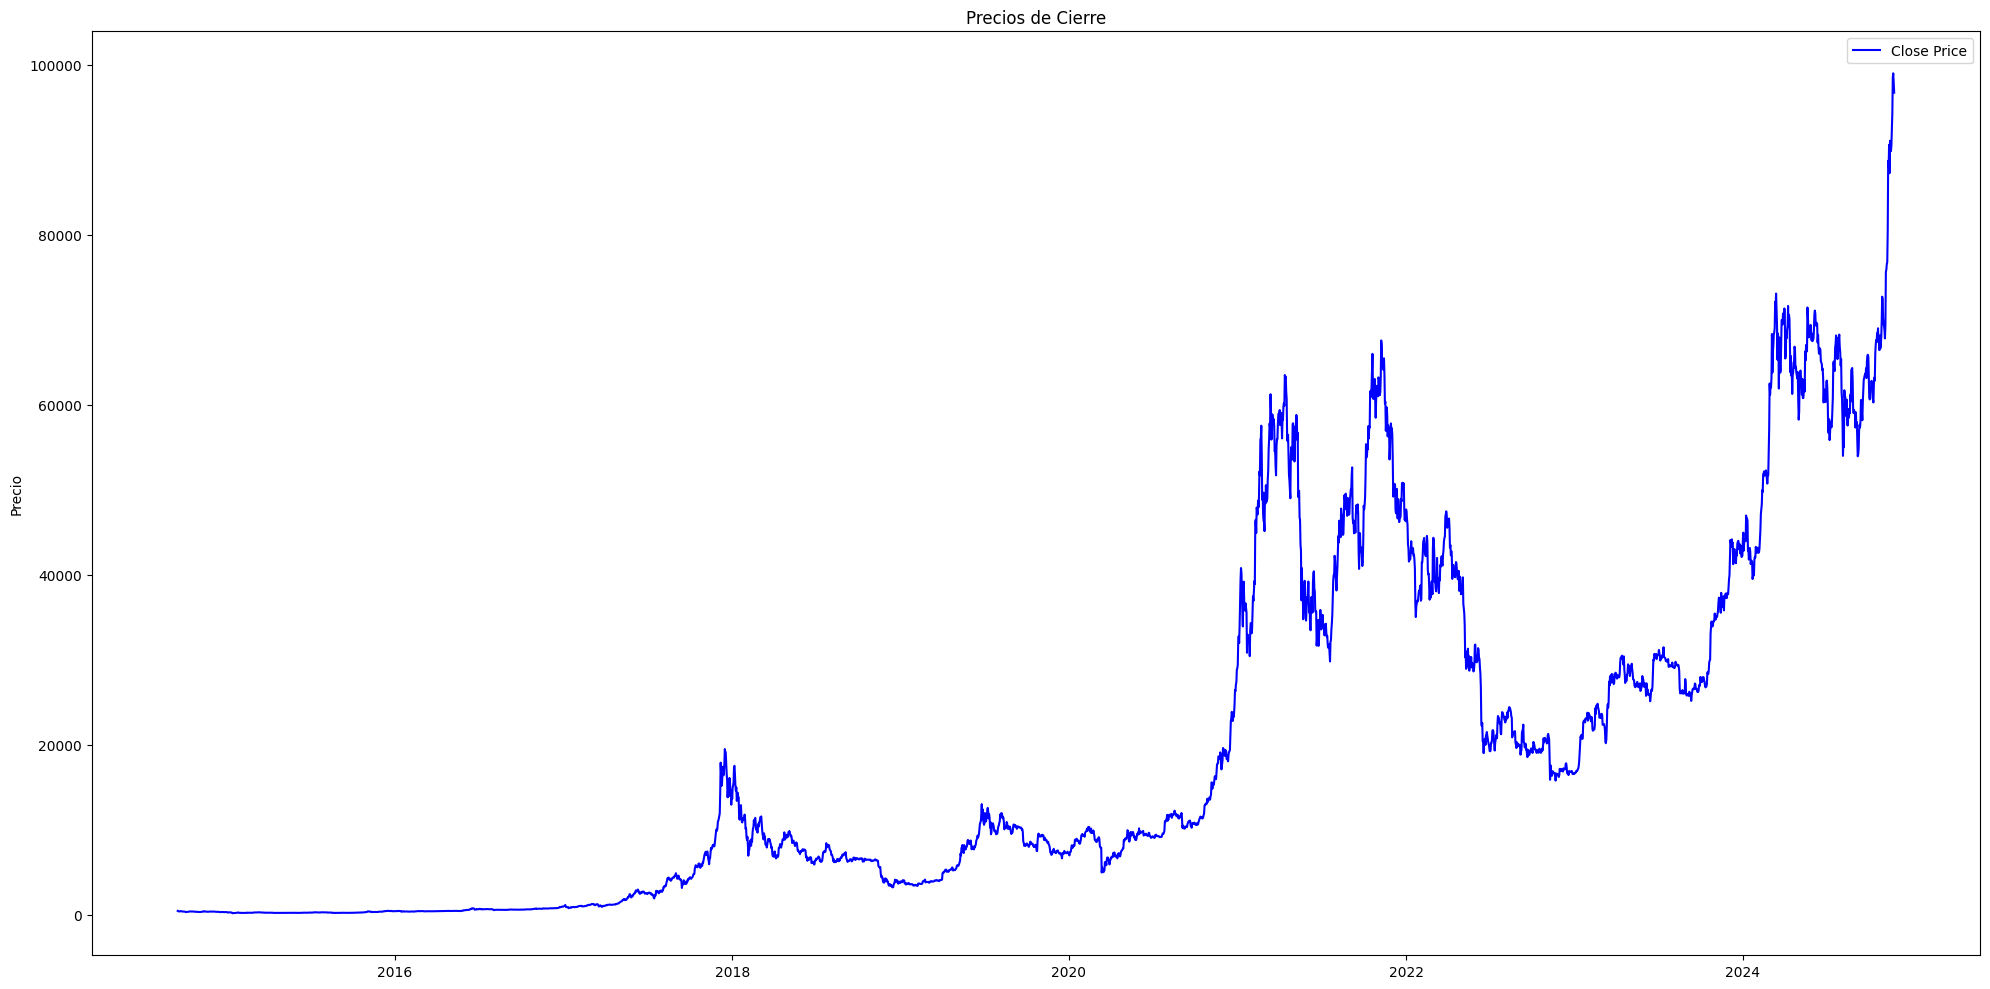

In [189]:
# Visualizacion
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 1, 1)  # Para precios y medias móviles
ax1.plot(data.index, data['Close'], label='Close Price', color='blue')

ax1.set_title('Precios de Cierre')
ax1.set_ylabel('Precio')
ax1.legend()
plt.tight_layout()
plt.show()


## Calculamos Indicadores

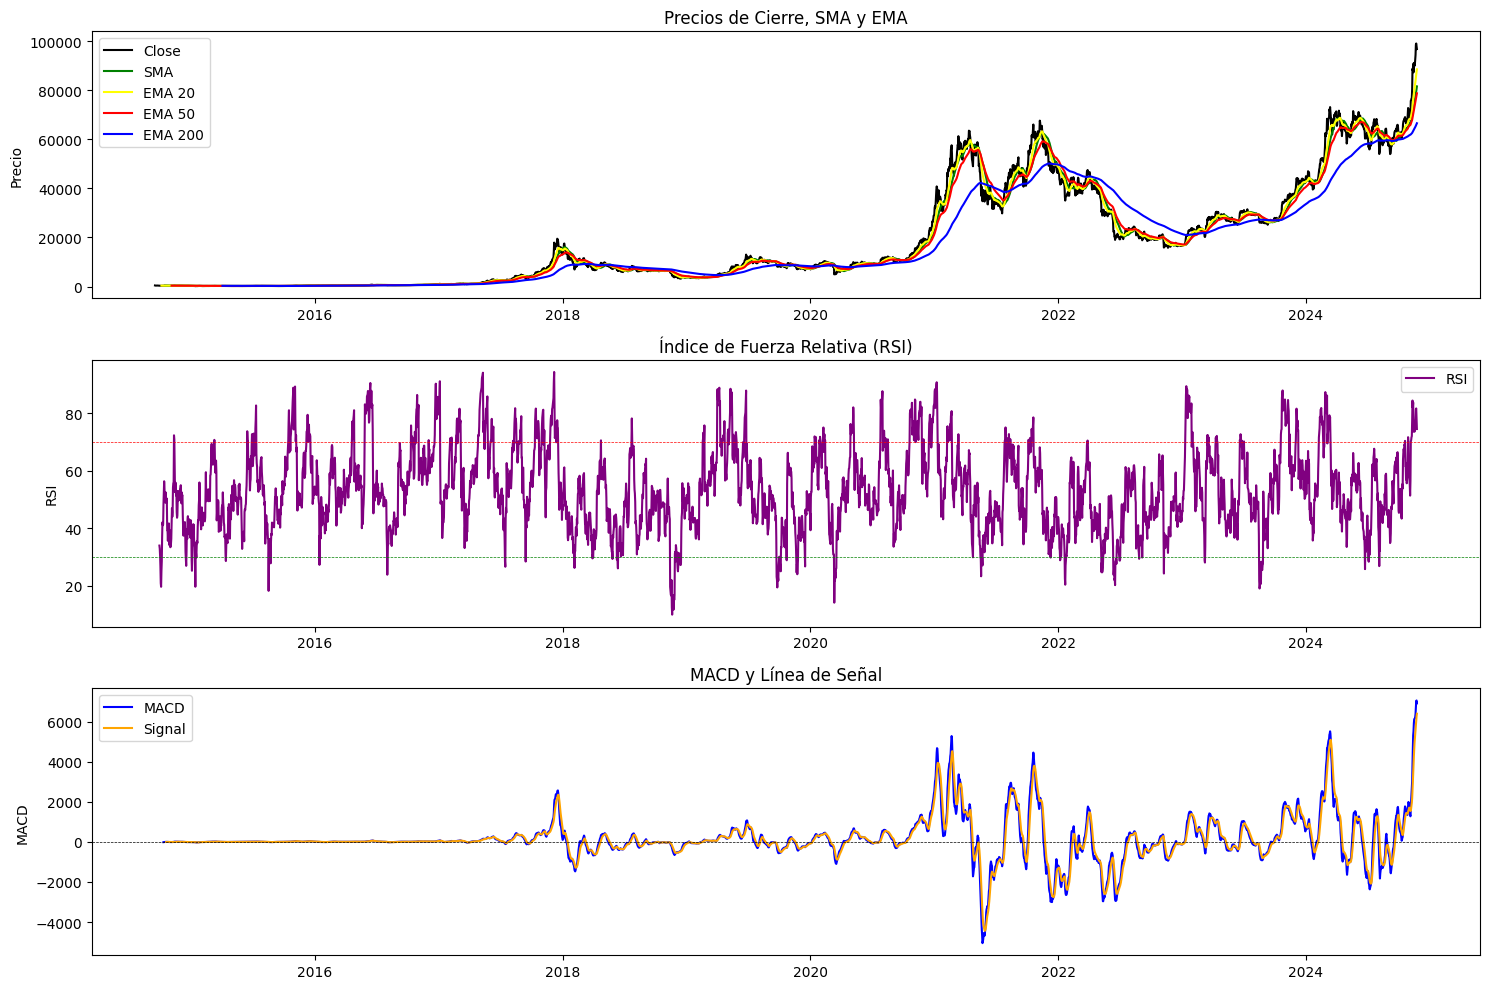

In [190]:
# Calcular indicadores
import ta
# Añadir medias móviles
data['sma'] = ta.trend.sma_indicator(data['Close'], window=30)
data['ema20'] = ta.trend.ema_indicator(data['Close'], window=20)
data['ema50'] = ta.trend.ema_indicator(data['Close'], window=50)
data['ema200'] = ta.trend.ema_indicator(data['Close'], window=200)


# Añadir RSI
data['rsi'] = ta.momentum.rsi(data['Close'], window=14)

# Añadir MACD
macd = ta.trend.MACD(data['Close'], window_slow=26, window_fast=12, window_sign=9)
data['macd'] = macd.macd()
data['macd_signal'] = macd.macd_signal()

# # Añadir Bandas de Bollinger
# bollinger = ta.volatility.BollingerBands(data['Close'], window=20, window_dev=2)
# data['bollinger_hband'] = bollinger.bollinger_hband()
# data['bollinger_lband'] = bollinger.bollinger_lband()
# data['bollinger_mavg'] = bollinger.bollinger_mavg()

# Configurar el tamaño de la figura
plt.figure(figsize=(15, 10))
# Crear subplots
ax1 = plt.subplot(3, 1, 1)  # Para precios y medias móviles
ax2 = plt.subplot(3, 1, 2, sharex=ax1)  # Para RSI
ax3 = plt.subplot(3, 1, 3, sharex=ax1)  # Para MACD
# Gráfico de precios, SMA y EMA
ax1.plot(data.index, data['Close'], label='Close', color='black')
ax1.plot(data.index, data['sma'], label='SMA', color='green')
ax1.plot(data.index, data['ema20'], label='EMA 20', color='yellow')
ax1.plot(data.index, data['ema50'], label='EMA 50', color='red')
ax1.plot(data.index, data['ema200'], label='EMA 200', color='blue')
ax1.set_title('Precios de Cierre, SMA y EMA')
ax1.set_ylabel('Precio')
ax1.legend()

# Gráfico de RSI
ax2.plot(data.index, data['rsi'], label='RSI', color='purple')
ax2.axhline(70, linestyle='--', color='red', linewidth=0.5)
ax2.axhline(30, linestyle='--', color='green', linewidth=0.5)
ax2.set_title('Índice de Fuerza Relativa (RSI)')
ax2.set_ylabel('RSI')
ax2.legend()

# Gráfico de MACD
ax3.plot(data.index, data['macd'], label='MACD', color='blue')
ax3.plot(data.index, data['macd_signal'], label='Signal', color='orange')
ax3.axhline(0, linestyle='--', color='black', linewidth=0.5)
ax3.set_title('MACD y Línea de Señal')
ax3.set_ylabel('MACD')
ax3.legend()

# Ajustar el layout y mostrar los gráficos
plt.tight_layout()
plt.show()

In [191]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Volume,sma,ema20,ema50,ema200,rsi,macd,macd_signal,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,,,,,,,,,
2015-04-04,253.697006,12493500,266.058734,255.661524,258.734938,307.338692,47.508324,-4.193133,-3.906538,254.322006,253.005005,247.272003,244.223999,247.526001,242.712997,252.798004
2015-04-05,260.597992,19649200,265.654567,256.131663,258.807999,306.873610,52.432292,-3.252122,-3.775655,253.697006,254.322006,253.005005,247.272003,244.223999,247.526001,242.712997
2015-04-06,255.492004,20034200,264.962268,256.070744,258.677960,306.362350,48.785829,-2.885117,-3.597547,260.597992,253.697006,254.322006,253.005005,247.272003,244.223999,247.526001
2015-04-07,253.179993,18467400,264.256468,255.795434,258.462354,305.833173,47.185618,-2.749132,-3.427864,255.492004,260.597992,253.697006,254.322006,253.005005,247.272003,244.223999
2015-04-08,245.022003,30086400,262.770301,254.769393,257.935281,305.228086,41.956153,-3.262042,-3.394700,253.179993,255.492004,260.597992,253.697006,254.322006,253.005005,247.272003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-20,94339.492188,71730956426,77397.952865,83808.010607,75353.658433,65220.437533,77.985220,6385.262124,5585.065444,92343.789062,90542.640625,89845.851562,90558.476562,91066.007812,87250.429688,90584.164062
2024-11-21,98504.726562,106024505582,78436.063542,85207.697841,76261.543458,65551.624489,81.278871,6764.311318,5820.914619,94339.492188,92343.789062,90542.640625,89845.851562,90558.476562,91066.007812,87250.429688
2024-11-22,98997.664062,78473580551,79521.579167,86521.027957,77153.156031,65884.420902,81.629162,7023.523663,6061.436428,98504.726562,94339.492188,92343.789062,90542.640625,89845.851562,90558.476562,91066.007812


In [192]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[2.53697006e+02, 1.24935000e+07, 2.66058734e+02, ...,
        2.47526001e+02, 2.42712997e+02, 2.52798004e+02],
       [2.60597992e+02, 1.96492000e+07, 2.65654567e+02, ...,
        2.44223999e+02, 2.47526001e+02, 2.42712997e+02],
       [2.55492004e+02, 2.00342000e+07, 2.64962268e+02, ...,
        2.47272003e+02, 2.44223999e+02, 2.47526001e+02],
       ...,
       [9.89976641e+04, 7.84735806e+10, 7.95215792e+04, ...,
        8.98458516e+04, 9.05584766e+04, 9.10660078e+04],
       [9.77772812e+04, 4.44146447e+10, 8.05087867e+04, ...,
        9.05426406e+04, 8.98458516e+04, 9.05584766e+04],
       [9.67257734e+04, 4.92229427e+10, 8.15115654e+04, ...,
        9.23437891e+04, 9.05426406e+04, 8.98458516e+04]])

#### Normalization

In [193]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np.shape

(3523, 16)

#### Train and Test

In [194]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((3523, 15), (3523,))

In [195]:
X = dc(np.flip(X, axis=1 ))
X

array([[-0.99906878, -0.99929079, -0.99919614, ..., -0.99941552,
        -0.99912313, -0.99998921],
       [-0.99929079, -0.99918484, -0.99926782, ..., -0.99940487,
        -0.99913308, -0.99994844],
       [-0.99918484, -0.99925752, -0.99920166, ..., -0.99940625,
        -0.99915011, -0.99994624],
       ...,
       [ 1.        ,  0.98882773,  0.94577557, ...,  0.95598454,
         0.95103449, -0.55286315],
       [ 0.98882773,  0.97314073,  0.96090125, ...,  0.9802844 ,
         0.97532568, -0.74695475],
       [ 0.97314073,  0.98847913,  1.        , ...,  1.        ,
         1.        , -0.71955371]])

In [196]:
split_index = int(len(X) * 0.0091)
split_index

32

In [197]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32, 15), (3491, 15), (32,), (3491,))

#### Add a dimension

In [198]:
X_train = X_train.reshape((-1, 15, 1))
X_test = X_test.reshape((-1, 15, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32, 15, 1), (3491, 15, 1), (32, 1), (3491, 1))

#### Convert the sets to Pytorch Tensors

In [199]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([32, 15, 1]),
 torch.Size([3491, 15, 1]),
 torch.Size([32, 1]),
 torch.Size([3491, 1]))

In [200]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [201]:
x_sample, y_sample = train_dataset[10]
print(x_sample.shape)  # Imprimirá torch.Size([15, 1])
print(y_sample.shape)  # Imprimirá torch.Size([1])

torch.Size([15, 1])
torch.Size([1])


In [202]:
from torch.utils.data import DataLoader

batch_size = 16 
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [203]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 15, 1]) torch.Size([16, 1])


#### Create the model

In [204]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

#### Function and training loop

In [205]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()


In [206]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()


In [207]:
learning_rate = 0.001
num_epochs = 30
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.982
***************************************************

Epoch: 2

Val Loss: 0.964
***************************************************

Epoch: 3

Val Loss: 0.946
***************************************************

Epoch: 4

Val Loss: 0.928
***************************************************

Epoch: 5

Val Loss: 0.910
***************************************************

Epoch: 6

Val Loss: 0.892
***************************************************

Epoch: 7

Val Loss: 0.874
***************************************************

Epoch: 8

Val Loss: 0.855
***************************************************

Epoch: 9

Val Loss: 0.837
***************************************************

Epoch: 10

Val Loss: 0.819
***************************************************

Epoch: 11

Val Loss: 0.802
***************************************************

Epoch: 12

Val Loss: 0.784
***************************************************

Epoch: 13

Val Loss: 0.766
**********************

### Visualizacion

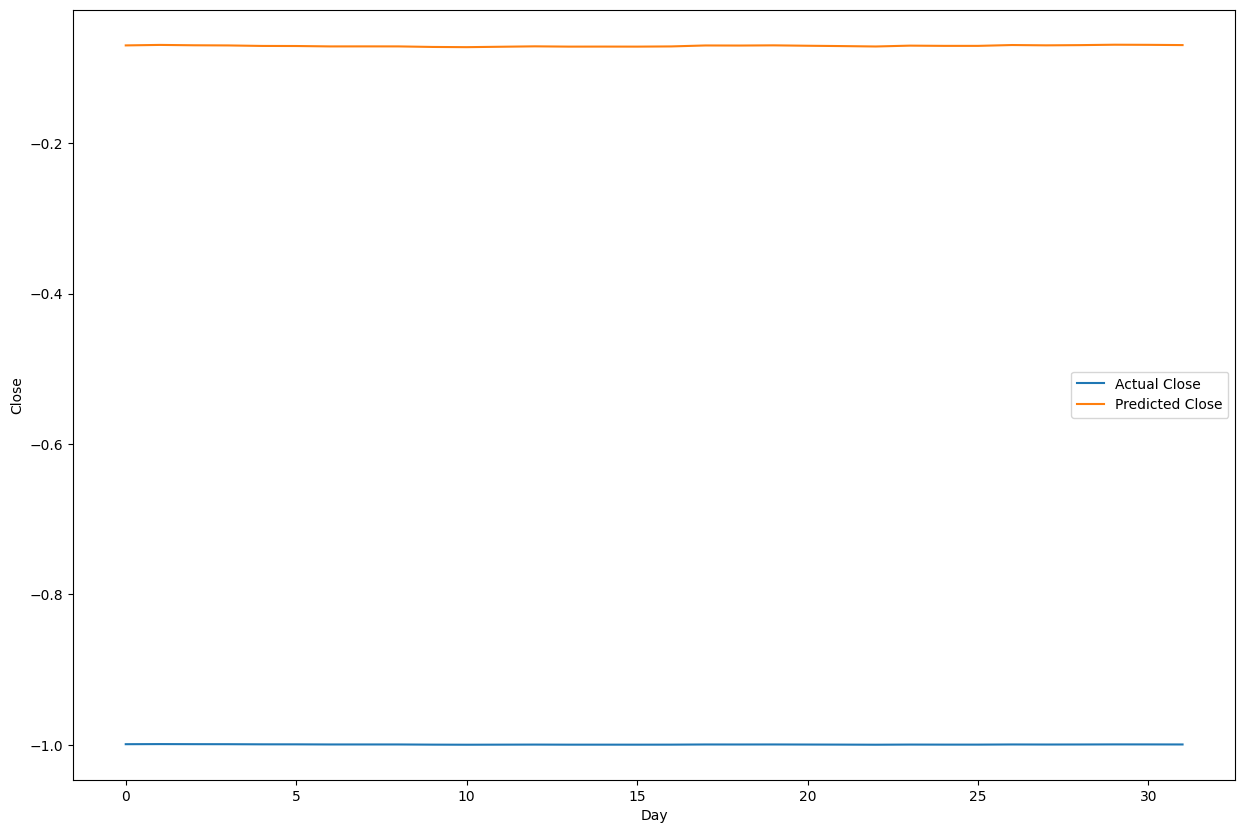

In [208]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()
    
plt.figure(figsize=(15, 10))
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

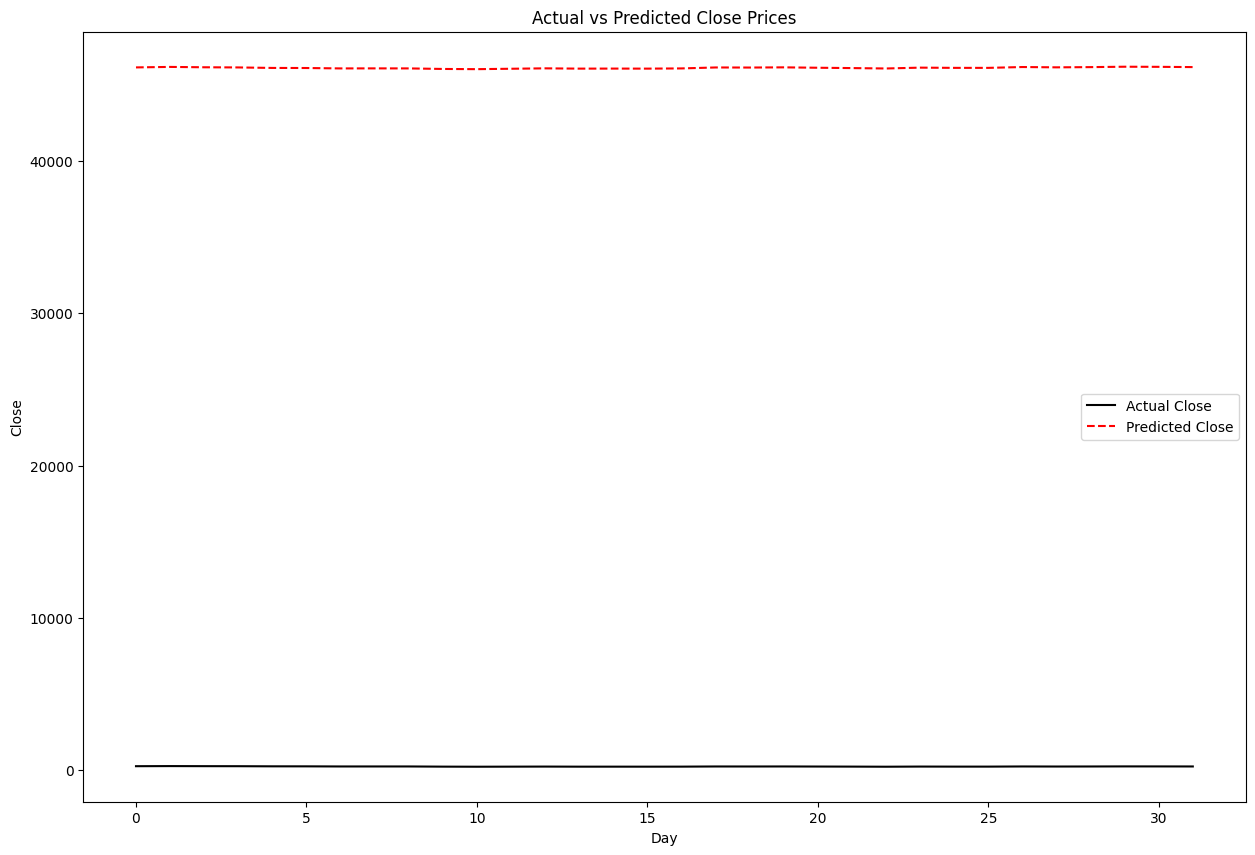

In [209]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()
    
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], 15+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions
dummies = np.zeros((X_train.shape[0], 15+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

plt.figure(figsize=(15, 10))

plt.plot(new_y_train, label='Actual Close', color='black')
plt.plot(train_predictions, label='Predicted Close', color='red', linestyle='--')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


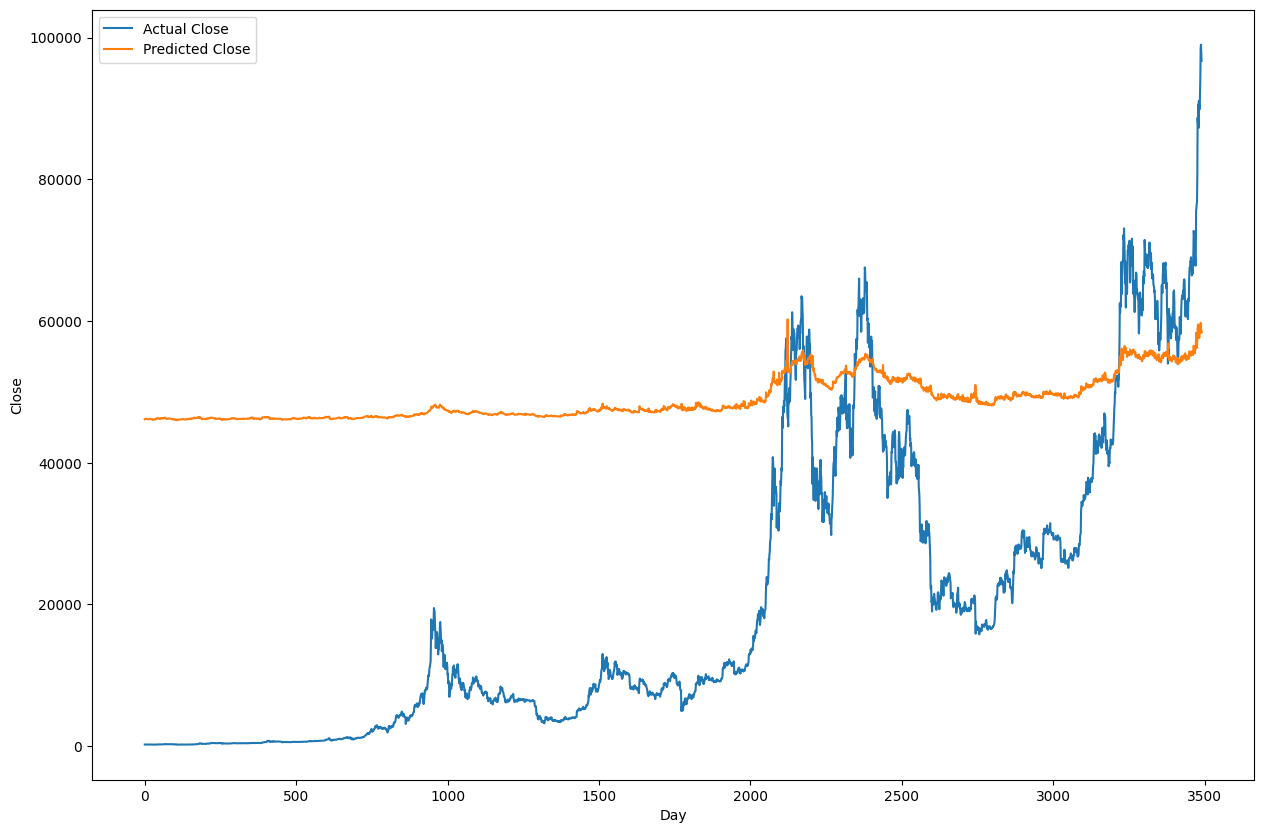

In [210]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], 15+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions
dummies = np.zeros((X_test.shape[0], 15+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

plt.figure(figsize=(15, 10))
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()